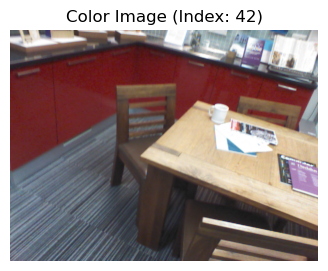

In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

class sevenScenesSequence:
    def __init__(self, base_folder, start_index, end_index):
    
        self.base_folder = base_folder
        self.start_index = start_index
        self.end_index = end_index

    def get_item(self, index):
        if not self.start_index <= index <= self.end_index:
            raise IndexError(f"Index {index} is out of range ({self.start_index}-{self.end_index})")

        padded_index = f"{index:06d}"
        color_path = os.path.join(self.base_folder, f"frame-{padded_index}.color.png")
        depth_path = os.path.join(self.base_folder, f"frame-{padded_index}.depth.png")
        pose_path = os.path.join(self.base_folder, f"frame-{padded_index}.pose.txt")

        if not all(os.path.exists(path) for path in [color_path, depth_path, pose_path]):
            raise FileNotFoundError(f"One or more files missing for index {index}")

        color_image = Image.open(color_path)
        depth_image = Image.open(depth_path)
        pose = np.loadtxt(pose_path)

        return {
            'color': color_image,
            'depth': depth_image,
            'pose': pose,
            'path' : color_path
        }

    def plot_image(self, index, image_type):
        """
        Plot a specific type of image for a given index.
        
        :param index: The index of the item to plot
        :param image_type: Either 'color' or 'depth'
        """
        if image_type not in ['color', 'depth']:
            raise ValueError("image_type must be either 'color' or 'depth'")

        try:
            item = self.get_item(index)
            
            plt.figure(figsize=(4, 3))
            
            if image_type == 'color':
                plt.imshow(item['color'])
                plt.title(f"Color Image (Index: {index})")
            else:  # depth
                depth_array = np.array(item['depth'])
                plt.imshow(depth_array, cmap='viridis')
                plt.title(f"Depth Image (Index: {index})")
            
            plt.axis('off')
            plt.show()
            
        except (IndexError, FileNotFoundError) as e:
            print(f"Error: {e}")

    def __len__(self):
        return self.end_index - self.start_index + 1

    def __getitem__(self, index):
        return self.get_item(index)

# Example usage:
sequence = sevenScenesSequence(base_folder='/home/bjangley/VPR/7scenes/redkitchen/seq-01', start_index=0, end_index=999)
sequence2 = sevenScenesSequence(base_folder='/datasets/7scenes_org/redkitchen/seq-01', start_index=0, end_index=999)

# Plot color image for index 42
sequence2.plot_image(42, 'color')

# # Plot depth image for index 42
# dataset.plot_image(42, 'depth')

def relative_transform(A, B):
    return np.dot(B, np.linalg.inv(A))

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

def visualize_sequence_with_slider(dataset):
    """
    Visualize the sequence of color images with an interactive slider using ipywidgets.
    
    :param dataset: An instance of SequenceDataset
    """
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(5, 4))
    plt.close(fig)  # Prevent the empty figure from displaying

    # Function to update the plot
    def update_plot(frame):
        ax.clear()
        item = dataset[frame]
        ax.imshow(item['color'])
        ax.set_title(f"Frame: {frame}")
        ax.axis('off')

    # Create the slider widget
    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(dataset) - 1,
        step=1,
        description='Frame:',
        continuous_update=False
    )

    # Create the output widget to display the plot
    out = widgets.Output()

    # Function to handle slider changes
    def on_value_change(change):
        with out:
            out.clear_output(wait=True)
            update_plot(change['new'])
            display(fig)

    # Connect the slider to the update function
    slider.observe(on_value_change, names='value')

    # Display initial plot
    with out:
        update_plot(0)
        display(fig)

    # Display the slider and the output
    display(widgets.VBox([slider, out]))

# Example usage:
# dataset = SequenceDataset()  # Assuming this is your dataset class
visualize_sequence_with_slider(sequence2)

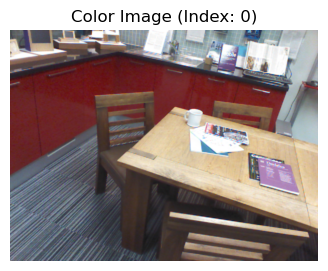

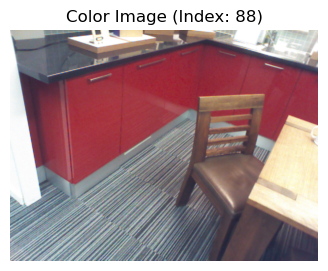

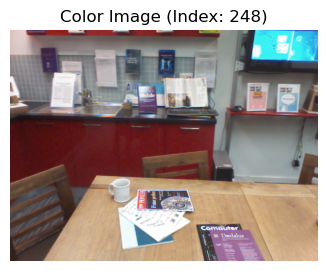

In [7]:
experiment1 = [0,88,248] #redkicthen
experiment2 = [79,213,281] #stairs -- seq2
# Plot color image for index 42
for x in experiment1:
    sequence2.plot_image(x,'color')

In [9]:
from utils import (
    getMasterOutout,
    scale_intrinsics,
    CameraMatrix,
    run_pnp,
    getImageFromIndex,
)

master_size = [512,384] #size of image used by mast3r

#imports for visualizing matches
import numpy as np

from matplotlib import pyplot as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cv2 #for pnp
from pyproj import Proj, transform #cartographic transformations and coordinate conversions

#supressing unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import os
from PIL import Image


import torch
from mast3r.model import AsymmetricMASt3R

#ensuring i dont exceed cpu limits?
import os
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"
os.environ["OMP_NUM_THREADS"] = "8"

def camera_b_to_a(camera_a_to_world, camera_b_to_world):
    #Inverse of camera A to world
    world_to_camera_a = np.linalg.inv(camera_a_to_world)
    
    # Camera B to A = (A to World)^-1 * (B to World)
    camera_b_to_a = np.dot(world_to_camera_a, camera_b_to_world)
    
    return camera_b_to_a

#load model
device = 'cuda:1'
model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)

>> Loading a list of 2 images
 - adding /datasets/7scenes_org/redkitchen/seq-01/frame-000000.color.png with resolution 640x480 --> 512x384
 - adding /datasets/7scenes_org/redkitchen/seq-01/frame-000248.color.png with resolution 640x480 --> 512x384
 (Found 2 images)
Mast3r Inference Time: 0.6530 seconds.
Point Matches Time: 0.2283 seconds.
Number of matches before confidence mask:  1190


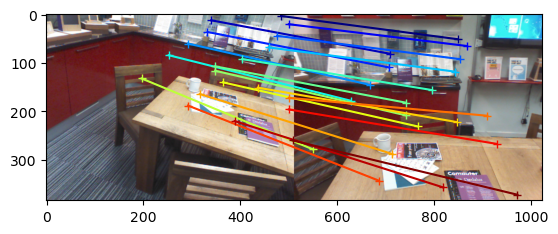

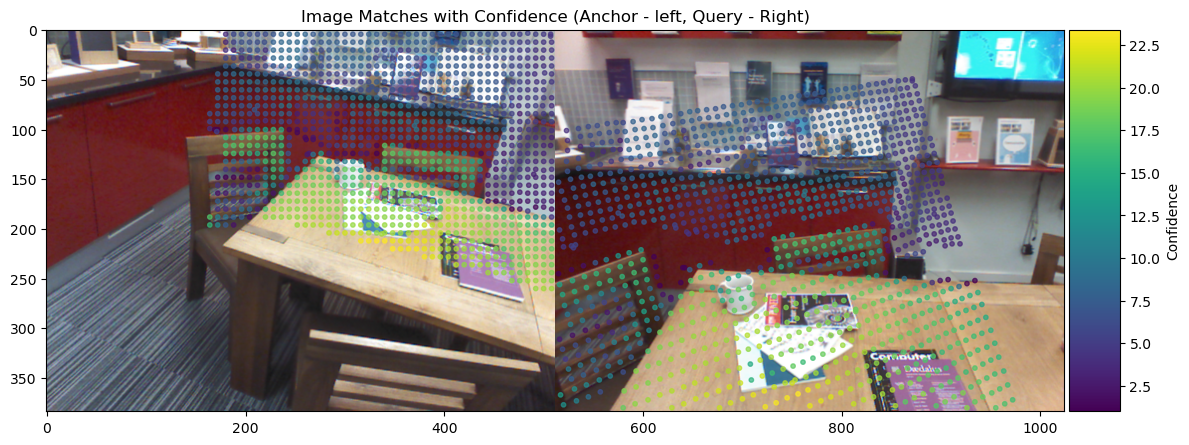

Number of matches after confidence mask:  10
[[ 0.94624148 -0.23329341  0.22405637  0.15021966]
 [ 0.26007462  0.96058536 -0.09816797 -0.21455568]
 [-0.19232333  0.15116198  0.96961941  0.22437138]
 [ 0.          0.          0.          1.        ]] 
 -------------------------------------------------
[[ 0.94326381 -0.20914473  0.25777633  0.11364016]
 [ 0.24367428  0.96358304 -0.10987947 -0.21172737]
 [-0.22542063  0.16646791  0.9599063   0.33011083]
 [ 0.          0.          0.          1.        ]]


In [12]:
corrected_data=[]

anchor_index = 0
query_index = 248

anchor = sequence2.get_item(anchor_index)
query = sequence2.get_item(query_index)


K = CameraMatrix(585,585,320,240) #camera_matrix from 7scenes link (for depth camera)
w = query['color'].size[0]
h = query['color'].size[1]
K_scaled = scale_intrinsics(K,w,h, master_size[0],master_size[1])

n_matches = 10


filtered_matches_im0,filtered_matches_im1,matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(model,device,anchor['path'], query['path'], n_matches,visualizeMatches=True)

ret_val, transformation = run_pnp(filtered_matches_im1.astype(np.float32), pts3d_im0[filtered_matches_im0[:, 1], filtered_matches_im0[:, 0], :].astype(np.float32), K_scaled.astype(np.float32))

if ret_val: 

    #transformations returned are cam to world -- anchor to world, query to world

    relative_pose = camera_b_to_a(anchor['pose'],query['pose']) #query to anchor
    print(transformation, '\n','-------------------------------------------------') 
    print(relative_pose)

>> Loading a list of 2 images
 - adding /datasets/7scenes_org/redkitchen/seq-01/frame-000000.color.png with resolution 640x480 --> 512x384
 - adding /datasets/7scenes_org/redkitchen/seq-01/frame-000248.color.png with resolution 640x480 --> 512x384
 (Found 2 images)
Mast3r Inference Time: 0.2472 seconds.
Point Matches Time: 0.1732 seconds.
Number of matches before confidence mask:  1190


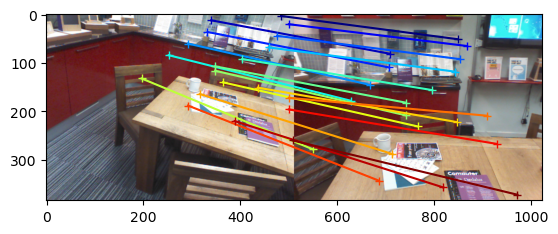

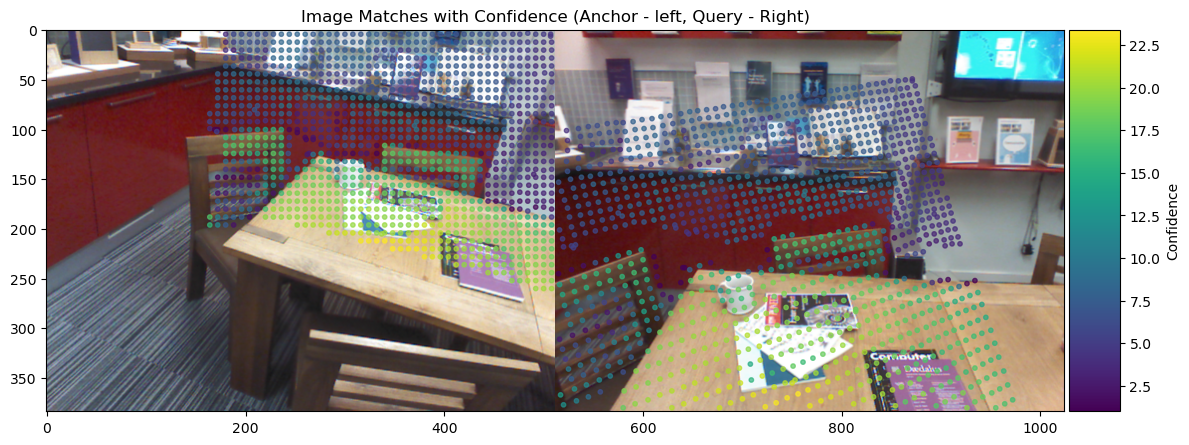

Number of matches after confidence mask:  10
[[ 0.94624148 -0.23329341  0.22405637  0.15021966]
 [ 0.26007462  0.96058536 -0.09816797 -0.21455568]
 [-0.19232333  0.15116198  0.96961941  0.22437138]
 [ 0.          0.          0.          1.        ]] 
 -------------------------------------------------
[[ 0.94326381 -0.20914473  0.25777633  0.11364016]
 [ 0.24367428  0.96358304 -0.10987947 -0.21172737]
 [-0.22542063  0.16646791  0.9599063   0.33011083]
 [ 0.          0.          0.          1.        ]]


In [15]:
corrected_data=[]

anchor_index = 0
query_index = 248

anchor = sequence2.get_item(anchor_index)
query = sequence2.get_item(query_index)


K = CameraMatrix(585,585,320,240) #camera_matrix from 7scenes link (for depth camera)
w = query['color'].size[0]
h = query['color'].size[1]
K_scaled = scale_intrinsics(K,w,h, master_size[0],master_size[1])

n_matches = 10
filtered_matches_im0,filtered_matches_im1,matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(model,device,anchor['path'], query['path'], n_matches,visualizeMatches=True)

ret_val, transformation = run_pnp(filtered_matches_im1.astype(np.float32), pts3d_im0[filtered_matches_im0[:, 1], filtered_matches_im0[:, 0], :].astype(np.float32), K_scaled.astype(np.float32))

if ret_val: 

    #transformations returned are cam to world -- anchor to world, query to world

    relative_pose = camera_b_to_a(anchor['pose'],query['pose']) #query to anchor
    print(transformation, '\n','-------------------------------------------------') 
    print(relative_pose)

In [ ]:
import os
import numpy as np
from collections import defaultdict
from PIL import Image
import torch
from torch.utils.data import Dataset

def camera_b_to_a(camera_a_to_world, camera_b_to_world):
    # Inverse of camera A to world
    world_to_camera_a = np.linalg.inv(camera_a_to_world)
    
    # Camera B to A = (A to World)^-1 * (B to World)
    camera_b_to_a = np.dot(world_to_camera_a, camera_b_to_world)
    
    return camera_b_to_a

class SevenScenesDataset(Dataset):
    def __init__(self, root_dir, pairs_file, stride=5, mast3r_output = None):
        self.root_dir = root_dir
        self.scenes_dict = {i: scene for i, scene in enumerate(['chess', 'fire', 'heads', 'office', 'pumpkin', 'redkitchen', 'stairs'])}
        
        query_paths, anchor_paths, scene_ids_query, scene_ids_anchor = self._read_pairs_txt(pairs_file)

        # Only keep every 5th item
        self.query_paths = query_paths[::stride]
        self.anchor_paths = anchor_paths[::stride]
        self.scene_ids_query = scene_ids_query[::stride]
        self.scene_ids_anchor = scene_ids_anchor[::stride]
        
        if mast3r_output:
            results = self._read_results_txt(mast3r_output)
            self.query_to_anchor = results[::stride]
        else:
            self.query_to_anchor = None

        self.query_to_anchor = self._read_results_txt(mast3r_output) if mast3r_output else None #to store results


    def _read_pairs_txt(self, pairs_file):
        query_paths, anchor_paths, scene_ids_query, scene_ids_anchor = [], [], [],[]
        
        with open(pairs_file, 'r') as f:
            for line in f:
                chunks = line.rstrip().split(' ')
                scene_id_query = int(chunks[2])
                scene_id_anchor = int(chunks[3])
                query_paths.append(os.path.join(self.root_dir, self.scenes_dict[scene_id_query], chunks[0][1:]))
                anchor_paths.append(os.path.join(self.root_dir, self.scenes_dict[scene_id_anchor], chunks[1][1:]))
                scene_ids_query.append(scene_id_query)
                scene_ids_anchor.append(scene_id_anchor)

        return query_paths, anchor_paths, scene_ids_query, scene_ids_anchor

    def _load_pose(self, image_path):
        pose_path = image_path.replace('.color.png', '.pose.txt')
        pose = np.loadtxt(pose_path)
        return pose
    
    def _read_results_txt(self, results_file):
        results = []
        with open(results_file, 'r') as f:
            for line in f:
                chunks = line.strip().split(' ')
                
                if len(chunks)>2:
                    transform = np.array([float(x) for x in chunks[2:]]).reshape(4, 4)
                    results.append(transform)
                else:
                    results.append(None)
        self.query_to_anchor = results

    def __getitem__(self, idx):
        query_img_path = self.query_paths[idx]
        anchor_img_path = self.anchor_paths[idx]
        
        query_img = Image.open(query_img_path).convert('RGB')
        anchor_img = Image.open(anchor_img_path).convert('RGB')
        
        scene_id_query = self.scene_ids_query[idx]
        scene_id_anchor = self.scene_ids_anchor[idx]
        
        query_pose = self._load_pose(query_img_path) #camera to world pose
        anchor_pose = self._load_pose(anchor_img_path) 

        gt_query_to_anchor = camera_b_to_a(anchor_pose, query_pose)

        mast3r_query_to_anchor = None
        if self.query_to_anchor[idx] is not None:
            mast3r_query_to_anchor = torch.FloatTensor(self.query_to_anchor[idx])



        return {
            'query_img': query_img,
            'anchor_img': anchor_img,
            'scene_name_query': self.scenes_dict[scene_id_query],
            'scene_name_anchor': self.scenes_dict[scene_id_anchor],
            'query_path': query_img_path,
            'anchor_path': anchor_img_path,
            'query_pose': query_pose,
            'anchor_pose': anchor_pose,
            'mast3r_q2a' : mast3r_query_to_anchor,
            'gt_query_to_anchor': gt_query_to_anchor
        }

    def __len__(self):
        return len(self.query_paths)
    
    def plotItem(self, idx):
        item = self[idx]

        # Extract images
        query_img = item['query_img']
        anchor_img = item['anchor_img']

        # Plot the images side by side
        plt.figure(figsize=(12, 6))
        
        # Plot the query image
        plt.subplot(1, 2, 1)
        plt.imshow(anchor_img)
        plt.title(f"Anchor Image\nScene: {item['scene_name_anchor']}")
        plt.axis('off')
        
        # Plot the anchor image
        plt.subplot(1, 2, 2)
        plt.imshow(query_img)
        plt.title(f"Query Image\nScene: {item['scene_name_query']}")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

In [19]:
dataset = SevenScenesDataset('/datasets/7scenes_org', '/home/bjangley/VPR/7scenes/NN_7scenes.txt')

print("Number of Image Pairs in dataset: ", len(dataset))
dataset._read_results_txt('/home/bjangley/VPR/7scenes/results_v3.txt')

Number of Image Pairs in dataset:  17000


In [ ]:
from tqdm import tqdm
K = CameraMatrix(585,585,320,240) #camera_matrix from 7scenes link (for depth camera)
n_matches = 10
output_file = '/home/bjangley/VPR/7scenes/results_dud.txt'

total_items = len(dataset)
update_interval = max(1, total_items // 10) 

with open(output_file, 'w') as f:
    pbar = tqdm(total=total_items, desc="Processing dataset", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')
    for i in range(total_items):
        pairs = dataset[i]
        anchor = pairs['anchor_img']
        query = pairs['query_img']
        #scale intrinsics

        w = query.size[0]
        h = query.size[1]
        K_scaled = scale_intrinsics(K,w,h, master_size[0],master_size[1])

        filtered_matches_im0,filtered_matches_im1,matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(model, device, pairs['anchor_path'], pairs['query_path'], n_matches,visualizeMatches=False,verboseFlag=False)

        # Predicted Transform copied from visloc.py
        ret_val, transformation = run_pnp(filtered_matches_im1.astype(np.float32), pts3d_im0[filtered_matches_im0[:, 1], filtered_matches_im0[:, 0], :].astype(np.float32), K_scaled.astype(np.float32))

        if ret_val:
            # Write anchor path, query path, and flattened transformation matrix
            f.write(f"{pairs['anchor_path']} {pairs['query_path']}")
            for value in transformation.flatten():
                f.write(f" {value}")
            f.write("\n") 
                # Update progress bar every 10% or at least once
        if (i + 1) % update_interval == 0 or i == total_items - 1:
            pbar.update(update_interval)
    pbar.close()

In [ ]:
K = CameraMatrix(585, 585, 320, 240)  # camera_matrix from 7scenes link (for depth camera)
n_matches = 20
output_file = '/home/bjangley/VPR/7scenes/results_v4.txt' #new output file just in case

total_items = len(dataset)
update_interval = max(1, total_items // 10)

# Start from a specific index
start_index = 0

# Open file in append mode
with open(output_file, 'a') as f:
    pbar = tqdm(total=total_items, desc="Processing dataset", initial=start_index,
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')
    for i in range(start_index, total_items):
        pairs = dataset[i]
        anchor_path = pairs['anchor_path']
        query_path = pairs['query_path']
        
        anchor = pairs['anchor_img']
        query = pairs['query_img']
        
        w = query.size[0]
        h = query.size[1]
        K_scaled = scale_intrinsics(K,w,h, master_size[0],master_size[1])
        filtered_matches_im0,filtered_matches_im1,matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(model, device, anchor_path, query_path, n_matches,visualizeMatches=False,verboseFlag=False)

        ret_val, transformation = run_pnp(filtered_matches_im1.astype(np.float32), pts3d_im0[filtered_matches_im0[:, 1], filtered_matches_im0[:, 0], :].astype(np.float32), K_scaled.astype(np.float32))

        if ret_val:
            f.write(f"{anchor_path} {query_path}")
            for value in transformation.flatten():
                f.write(f" {value}")
            f.write("\n")
            f.flush()  # Ensure the data is written to the file immediately
        else:
            f.write(f"{anchor_path} {query_path}")
            f.write("\n")
            f.flush()
        
        pbar.update(1)
    pbar.close()

K = CameraMatrix(585, 585, 320, 240)  # camera_matrix from 7scenes link (for depth camera)
 n_matches = 20
 output_file = '/home/bjangley/VPR/7scenes/results_v4.txt' #new output file just in case
 
 total_items = len(dataset)
 update_interval = max(1, total_items // 10)
 
 # Start from a specific index
 start_index = 0
 
 # Open file in append mode
 with open(output_file, 'a') as f:
     pbar = tqdm(total=total_items, desc="Processing dataset", initial=start_index,
                 bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')
     for i in range(start_index, total_items):
         pairs = dataset[i]
         anchor_path = pairs['anchor_path']
         query_path = pairs['query_path']
         
         anchor = pairs['anchor_img']
         query = pairs['query_img']
         
         w = query.size[0]
         h = query.size[1]
         K_scaled = scale_intrinsics(K,w,h, master_size[0],master_size[1])
         filtered_matches_im0,filtered_matches_im1,matches_im0, matches_im1, pts3

In [22]:
import numpy as np

def load_results(output_file):
    """
    Loads anchor paths, query paths, and transformations from the output file.

    Args:
        output_file (str): Path to the output file.

    Returns:
        list: A list of dictionaries, where each dictionary contains
            'anchor_path', 'query_path', and 'transformation' (as a NumPy array
            or None if 'none' was written).
    """
    results = []
    with open(output_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            anchor_path = parts[0]
            query_path = parts[1]

            if len(parts) == 2:
                transformation = None  # No transformation found
            else:
                transformation_values = parts[2:]
                if 'none' in transformation_values:
                    transformation = None
                else:
                    transformation = np.array([float(val) for val in transformation_values]).reshape(4, 4) # Assuming transformation values were generated by transformation.flatten()
            results.append({
                'anchor_path': anchor_path,
                'query_path': query_path,
                'transformation': transformation
            })
    return results

# Example usage:
output_file = '/home/bjangley/VPR/7scenes/results_v3.txt'
results = load_results(output_file)

# # Now you can iterate through the results and access the data:
# for result in results:
#     # anchor_path = result['anchor_path']
#     # query_path = result['query_path']
#     # transformation = result['transformation']

#     # print(f"Anchor Path: {anchor_path}")
#     # print(f"Query Path: {query_path}")
#     # if transformation is not None:
#     #     print("Transformation:")
#     #     print(transformation)
#     # else:
#     #     print("No valid transformation found.")

# Compare with the dataset and print progress
# with tqdm(total=len(dataset), desc="Comparing pairs") as pbar:
#     for i in range(len(dataset)):
#         if results[i]['anchor_path'] != dataset[i]['anchor_path']:
#             print("anchor mismatch @ ", i)
#             break
#         elif results[i]['query_path'] != dataset[i]['query_path']:
#             print("query mismatch @ ", i)
#             break
#         pbar.update(1)

# print("Finished comparing.")

index_fails = []
for i in range(len(results)):
    if results[i]['transformation'] is None:
        index_fails.append(i)
print(index_fails)

[8546, 8553, 8555, 8556, 8564, 8571, 8572, 8573, 8574, 15964, 15967, 15970, 15971, 15972, 15976, 15977, 15978, 15979, 15981, 15982, 15983, 15984, 15985, 15986, 15987, 15988, 15989, 15990, 15992, 15993, 15996, 16103, 16659, 16660, 16662, 16663, 16664, 16665, 16666, 16667, 16668, 16669, 16670, 16672, 16675, 16676, 16677, 16678, 16679, 16680, 16681, 16682, 16683, 16684, 16685, 16686, 16690, 16691, 16692, 16693, 16694, 16695, 16696]


In [24]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import tabulate

def compute_pose_error(est_pose, gt_pose):
    # Compute positional error
    pos_error = np.linalg.norm(est_pose[:3, 3] - gt_pose[:3, 3])
    
    est_quat = R.from_matrix(est_pose[:3, :3]).as_quat()
    gt_quat = R.from_matrix(gt_pose[:3, :3]).as_quat()
    est_quat = np.concatenate(([est_quat[3]], est_quat[:3]))
    gt_quat = np.concatenate(([gt_quat[3]], gt_quat[:3]))
    # Compute the quaternion dot product and account for double covering.
    dot = np.clip(np.abs(np.dot(est_quat, gt_quat)), -1.0, 1.0)
    theta = 2 * np.arccos(dot)
    
    rot_error = np.degrees(theta)

    # # Compute rotational error
    # R_diff = np.dot(est_pose[:3, :3], gt_pose[:3, :3].T)
    # rot_error = np.degrees(np.arccos((np.trace(R_diff) - 1) / 2))
    
    return pos_error, rot_error



import numpy as np
from scipy.spatial.transform import Rotation
from collections import defaultdict
from tabulate import tabulate

def analyze_query_to_anchor(gt_query_to_anchor):
    # Extract translation
    translation = np.linalg.norm(gt_query_to_anchor[:3, 3])
    
    # Extract rotation as quaternion
    rotation = Rotation.from_matrix(gt_query_to_anchor[:3, :3])
    quat = rotation.as_quat()
    angle = 2 * np.arccos(np.abs(quat[3])) * 180 / np.pi  # Convert to degrees
    
    return translation, angle

def compute_dataset_stats(dataset):
    scene_data = defaultdict(lambda: {'translations': [], 'rotations': []})
    overall_translations = []
    overall_rotations = []

    for i in range(len(dataset)):
        item = dataset[i]
        gt_query_to_anchor = item['gt_query_to_anchor']
        scene = item['scene_name_query']
        
        translation, rotation = analyze_query_to_anchor(gt_query_to_anchor)
        
        scene_data[scene]['translations'].append(translation)
        scene_data[scene]['rotations'].append(rotation)
        overall_translations.append(translation)
        overall_rotations.append(rotation)

    # Compute overall statistics
    overall_stats = {
        'Translation Mean': np.mean(overall_translations),
        'Translation Median': np.median(overall_translations),
        'Rotation Mean': np.mean(overall_rotations),
        'Rotation Median': np.median(overall_rotations)
    }

    # Compute per-scene statistics
    scene_stats = {}
    for scene, data in scene_data.items():
        scene_stats[scene] = {
            'Translation Mean': np.mean(data['translations']),
            'Translation Median': np.median(data['translations']),
            'Rotation Mean': np.mean(data['rotations']),
            'Rotation Median': np.median(data['rotations'])
        }

    return overall_stats, scene_stats

def print_stats_tables(overall_stats, scene_stats):
    # Overall statistics table
    overall_table = [
        ['Metric', 'Translation (meters)', 'Rotation (degrees)'],
        ['Mean', f"{overall_stats['Translation Mean']:.3f}", f"{overall_stats['Rotation Mean']:.3f}"],
        ['Median', f"{overall_stats['Translation Median']:.3f}", f"{overall_stats['Rotation Median']:.3f}"]
    ]
    print("Overall Statistics of Query-to-Anchor Transformations:")
    print(tabulate(overall_table, headers='firstrow', tablefmt='grid'))
    print("\n")

    # Per-scene statistics table
    scene_table = [['Scene', 'Trans Mean (m)', 'Trans Median (m)', 'Rot Mean (deg)', 'Rot Median (deg)']]
    for scene, stats in scene_stats.items():
        scene_table.append([
            scene,
            f"{stats['Translation Mean']:.3f}",
            f"{stats['Translation Median']:.3f}",
            f"{stats['Rotation Mean']:.3f}",
            f"{stats['Rotation Median']:.3f}"
        ])
    print("Per-Scene Statistics of Query-to-Anchor Transformations:")
    print(tabulate(scene_table, headers='firstrow', tablefmt='grid'))


# overall_stats, scene_stats = compute_dataset_stats(dataset)
# print_stats_tables(overall_stats, scene_stats)

In [26]:
import json
def save_stats_to_json(overall_stats, scene_stats, filename="dataset_stats.json"):
    stats_to_save = {
        'overall': {k: float(v) for k, v in overall_stats.items()},
        'scenes': {scene: {k: float(v) for k, v in scene_stats.items()} 
                for scene, scene_stats in scene_stats.items()}
    }
    
    with open(filename, 'w') as f:
        json.dump(stats_to_save, f, indent=4)

# # Save the stats to a JSON file
# save_stats_to_json(overall_stats, scene_stats)

# To load the stats later, you can use:
def load_stats_from_json(filename="dataset_stats.json"):
    with open(filename, 'r') as f:
        return json.load(f)
    
# Example of loading:
loaded_stats = load_stats_from_json()
print_stats_tables(loaded_stats['overall'], loaded_stats['scenes'])
# print(loaded_stats['overall'])
# print(loaded_stats['scenes']['chess'])  # Assuming 'chess' is one of your scenes

Overall Statistics of Query-to-Anchor Transformations:
+----------+------------------------+----------------------+
| Metric   |   Translation (meters) |   Rotation (degrees) |
+==========+========================+======================+
| Mean     |                  0.349 |               14.381 |
+----------+------------------------+----------------------+
| Median   |                  0.284 |               12.914 |
+----------+------------------------+----------------------+


Per-Scene Statistics of Query-to-Anchor Transformations:
+------------+------------------+--------------------+------------------+--------------------+
| Scene      |   Trans Mean (m) |   Trans Median (m) |   Rot Mean (deg) |   Rot Median (deg) |
+============+==================+====================+==================+====================+
| fire       |            0.338 |              0.318 |           15.616 |             14.401 |
+------------+------------------+--------------------+------------------+------

In [28]:
def collect_localization_data(dataset, final_index=None):
    thresholds = [(0.25, 5), (0.25, 10), (0.5, 5), (0.5, 10), (1, 5), (1, 10), (2, 5)]
    pos_thresholds = [0.25, 0.5, 1]
    scene_data = defaultdict(lambda: {
        'total': 0,
        'success_counts': [0] * len(thresholds),
        'pos_success_counts': [0] * len(pos_thresholds),
        'pos_errors': [],
        'rot_errors': []
    })
    total_count = 0

    range_to_evaluate = range(final_index) if final_index else range(len(dataset))

    for i in range_to_evaluate:
        item = dataset[i]
        if item['mast3r_q2a'] is not None:
            est_pose = item['mast3r_q2a'].numpy()
            gt_pose = item['gt_query_to_anchor']
            scene = item['scene_name_query']
            
            pos_error, rot_error = compute_pose_error(est_pose, gt_pose)
            
            scene_data[scene]['total'] += 1
            scene_data[scene]['pos_errors'].append(pos_error)
            scene_data[scene]['rot_errors'].append(rot_error)
            
            for i, (pos_thresh, rot_thresh) in enumerate(thresholds):
                if pos_error <= pos_thresh and rot_error <= rot_thresh:
                    scene_data[scene]['success_counts'][i] += 1
            
            for i, pos_thresh in enumerate(pos_thresholds):
                if pos_error <= pos_thresh:
                    scene_data[scene]['pos_success_counts'][i] += 1
            
            total_count += 1

    return scene_data, total_count

def calculate_statistics(scene_data, total_count):
    thresholds = [(0.25, 5), (0.25, 10), (0.5, 5), (0.5, 10), (1, 5), (1, 10), (2, 5)]
    pos_thresholds = [0.25, 0.5, 1]
    results = {}
    for scene, data in scene_data.items():
        results[scene] = {
            'total': data['total'],
            'median_pos_error': np.median(data['pos_errors']),
            'median_rot_error': np.median(data['rot_errors']),
            'mean_pos_error': np.mean(data['pos_errors']),
            'mean_rot_error': np.mean(data['rot_errors']),
            'success_rates': [count / data['total'] * 100 for count in data['success_counts']],
            'pos_success_rates': [count / data['total'] * 100 for count in data['pos_success_counts']]
        }

    overall_success_rates = [sum(data['success_counts'][i] for data in scene_data.values()) / total_count * 100 for i in range(len(thresholds))]
    overall_pos_success_rates = [sum(data['pos_success_counts'][i] for data in scene_data.values()) / total_count * 100 for i in range(len(pos_thresholds))]
    overall_median_pos_error = np.median([error for data in scene_data.values() for error in data['pos_errors']])
    overall_median_rot_error = np.median([error for data in scene_data.values() for error in data['rot_errors']])

    return results, overall_success_rates, overall_pos_success_rates, overall_median_pos_error, overall_median_rot_error

# Usage:
final_index = len(dataset.query_to_anchor)-1
scene_data, total_count = collect_localization_data(dataset, final_index)

# Calculate statistics
results, overall_success_rates, overall_pos_success_rates, overall_median_pos_error, overall_median_rot_error = calculate_statistics(scene_data, total_count)

# Print results
from tabulate import tabulate

scenes = list(results.keys())
metrics = ["Total images", "Median Position Error", "Mean Position Error", "Median Rotational Error", "Mean Rotational Error"] + \
        [f"({pos_thresh}m, {rot_thresh}°)" for pos_thresh, rot_thresh in [(0.25, 5), (0.25, 10), (0.5, 5), (0.5, 10), (1, 5), (1, 10), (2, 5)]] + \
        [f"Position only ({thresh}m)" for thresh in [0.25, 0.5, 1]]

table_data = []
for metric in metrics:
    row = [metric]
    for scene in scenes:
        if metric == "Total images":
            row.append(results[scene]['total'])
        elif metric == "Median Position Error":
            row.append(f"{results[scene]['median_pos_error']:.3f}m")
        elif metric == "Mean Position Error":
            row.append(f"{results[scene]['mean_pos_error']:.3f}m")
        elif metric == "Median Rotational Error":
            row.append(f"{results[scene]['median_rot_error']:.3f}°")
        elif metric == "Mean Rotational Error":
            row.append(f"{results[scene]['mean_rot_error']:.3f}°")
        elif metric.startswith("("):
            i = metrics.index(metric) - 5
            row.append(f"{results[scene]['success_rates'][i]:.2f}%")
        elif metric.startswith("Position only"):
            i = metrics.index(metric) - 12
            row.append(f"{results[scene]['pos_success_rates'][i]:.2f}%")
    table_data.append(row)

# Add overall statistics
table_data.append(["Overall"] + ["" for _ in scenes])
table_data.append(["Total images", total_count] + ["" for _ in scenes[1:]])
table_data.append(["Overall Median Position Error", f"{overall_median_pos_error:.3f}m"] + ["" for _ in scenes[1:]])
table_data.append(["Overall Median Rotation Error", f"{overall_median_rot_error:.3f}°"] + ["" for _ in scenes[1:]])

# Add overall success rates
for i, (pos_thresh, rot_thresh) in enumerate([(0.25, 5), (0.25, 10), (0.5, 5), (0.5, 10), (1, 5), (1, 10), (2, 5)]):
    table_data.append([f"Overall ({pos_thresh}m, {rot_thresh}°)", f"{overall_success_rates[i]:.2f}%"] + ["" for _ in scenes[1:]])

# Add overall position-only success rates
for i, thresh in enumerate([0.25, 0.5, 1]):
    table_data.append([f"Overall Position only ({thresh}m)", f"{overall_pos_success_rates[i]:.2f}%"] + ["" for _ in scenes[1:]])

# Print the table
print(tabulate(table_data, headers=["Metric"] + scenes, tablefmt="grid"))

+-------------------------------+--------+----------+---------+---------+----------+--------------+-----------+
| Metric                        | fire   | office   | chess   | heads   | stairs   | redkitchen   | pumpkin   |
+===============================+========+==========+=========+=========+==========+==============+===========+
| Total images                  | 2000   | 4000     | 2000    | 991     | 1000     | 5000         | 1945      |
+-------------------------------+--------+----------+---------+---------+----------+--------------+-----------+
| Median Position Error         | 0.156m | 0.219m   | 0.158m  | 0.176m  | 0.209m   | 0.164m       | 0.252m    |
+-------------------------------+--------+----------+---------+---------+----------+--------------+-----------+
| Mean Position Error           | 0.250m | 0.250m   | 0.171m  | 0.359m  | 0.264m   | 0.198m       | 0.372m    |
+-------------------------------+--------+----------+---------+---------+----------+--------------+-----

In [30]:
n = 8
print(dataset[n]['gt_query_to_anchor'])
print(dataset[n]['mast3r_q2a'])
print(dataset[n]['query_path'])

[[ 0.99092063 -0.08855709  0.10180187  0.19513381]
 [ 0.09330632  0.99478702 -0.04288771 -0.03376043]
 [-0.09746483  0.05198891  0.99395408 -0.19374004]
 [ 0.          0.          0.          1.        ]]
tensor([[ 0.9914, -0.0880,  0.0970,  0.2004],
        [ 0.0902,  0.9958, -0.0184, -0.0787],
        [-0.0949,  0.0270,  0.9951, -0.4093],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
/datasets/7scenes_org/fire/seq-03/frame-000008.color.png


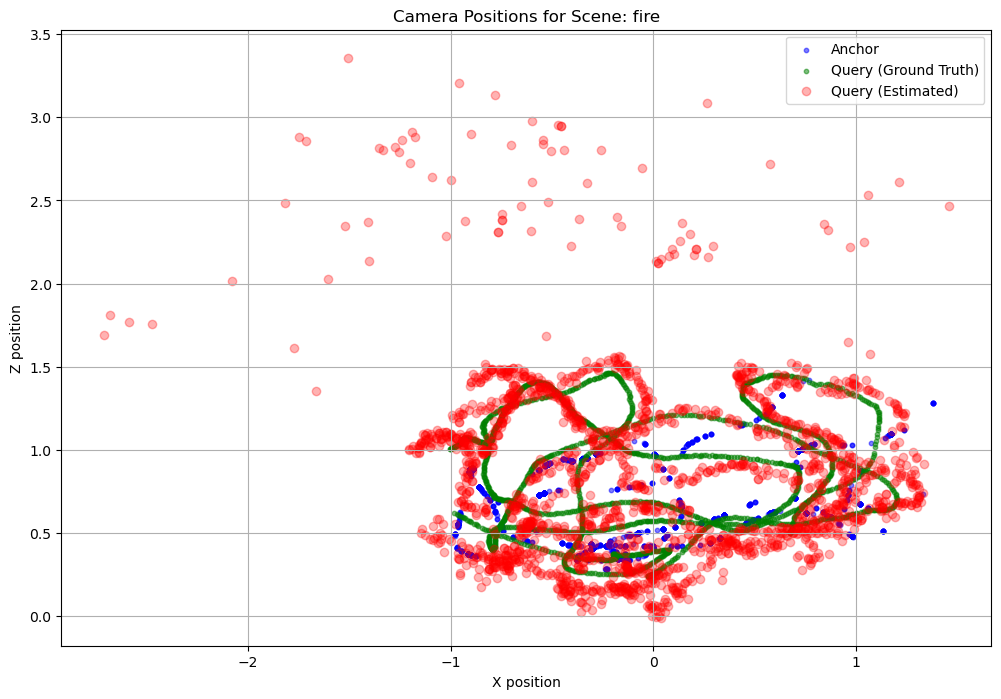

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plotScene(dataset, scene_name, save_path=None):
    # Scene names in the correct order and their respective number of images
    scene_names = ['fire', 'office', 'chess', 'heads', 'stairs', 'redkitchen', 'pumpkin']
    scene_sizes = [2000, 4000, 2000, 1000, 1000, 5000, 2000]  # Corresponding sizes

    # Check if the scene name is valid
    if scene_name not in scene_names:
        print(f"Error: Scene '{scene_name}' not found. Available scenes: {scene_names}")
        return

    # Find the start index and size for the specified scene
    scene_idx = scene_names.index(scene_name)
    start_idx = sum(scene_sizes[:scene_idx])  # Sum of sizes before this scene
    scene_size = scene_sizes[scene_idx]

    # Lists to store positions
    anchor_x, anchor_z = [], []
    query_x, query_z = [], []
    estimated_x, estimated_z = [], []

    # Process data for the specified scene
    for idx in range(start_idx, start_idx + scene_size):
        item = dataset[idx]

        # Anchor position
        anchor_position = item['anchor_pose'][:3, 3]
        anchor_x.append(anchor_position[0])
        anchor_z.append(anchor_position[2])

        # Query position (ground truth)
        query_position = item['query_pose'][:3, 3]
        query_x.append(query_position[0])
        query_z.append(query_position[2])

        # Estimated query position
        if item['mast3r_q2a'] is not None:
            estimated_query_pose = np.dot(item['anchor_pose'], item['mast3r_q2a'].numpy())
            estimated_query_position = estimated_query_pose[:3, 3]
            estimated_x.append(estimated_query_position[0])
            estimated_z.append(estimated_query_position[2])

    # Plot for the specified scene
    plt.figure(figsize=(12, 8))
    plt.scatter(anchor_x, anchor_z, s=10,c='blue', label='Anchor', alpha=0.5)
    plt.scatter(query_x, query_z, s=10,c='green', label='Query (Ground Truth)', alpha=0.5)

    if len(estimated_x) > 0:
        plt.scatter(estimated_x, estimated_z, c='red', label='Query (Estimated)', alpha=0.3)

    plt.title(f'Camera Positions for Scene: {scene_name}')
    plt.xlabel('X position')
    plt.ylabel('Z position')
    plt.legend()
    plt.grid(True)
    # plt.savefig(f'{scene_name}_positions.png')
    # plt.close()
    plt.show()
    # print(f"Plot saved for scene: {scene_name}")
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        file_path = os.path.join(save_path, f'{scene_name}.png')
        plt.savefig(file_path)
    


plotScene(dataset=dataset, scene_name='fire')

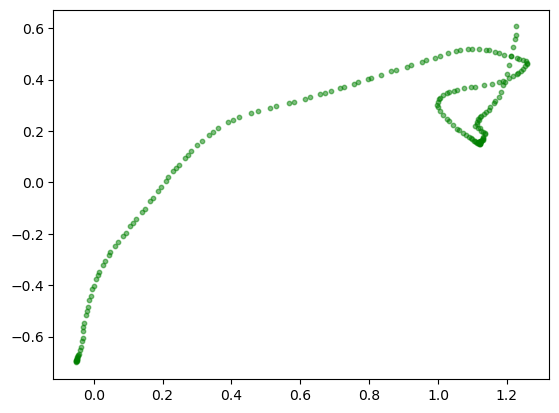

In [4]:
from sevenScenesDatasets import SevenScenesNBDataset
import matplotlib.pyplot as plt
root_dir = '/datasets/7scenes_org'
pairs_file = '/home/bjangley/VPR/7scenes/pairs2/test_tuples_multiimagerelposenet.txt'
output_file2 = '/home/bjangley/VPR/7scenes/pairs2/results_n30_v1_1.txt'
dataset = SevenScenesNBDataset(root_dir, pairs_file, mast3r_output=output_file2)


gt_query_x, gt_query_z = [],[]
for i in range(200):
    query_pose = dataset[i]['gt_query_pose'][:3, 3]
    gt_query_x.append(query_pose[0])
    gt_query_z.append(query_pose[2])
plt.scatter(gt_query_x, gt_query_z, s=10, c='green', label='Query (Ground Truth)', alpha=0.5)   
plt.show()

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm
import matplotlib.pyplot as plt

def compute_pose_error(est_pose, gt_pose):
    # Compute positional error
    pos_error = np.linalg.norm(est_pose[:3, 3] - gt_pose[:3, 3])
    
    est_quat = R.from_matrix(est_pose[:3, :3]).as_quat()
    gt_quat = R.from_matrix(gt_pose[:3, :3]).as_quat()
    est_quat = np.concatenate(([est_quat[3]], est_quat[:3]))
    gt_quat = np.concatenate(([gt_quat[3]], gt_quat[:3]))
    # Compute the quaternion dot product and account for double covering.
    dot = np.clip(np.abs(np.dot(est_quat, gt_quat)), -1.0, 1.0)
    theta = 2 * np.arccos(dot)
    
    rot_error = np.degrees(theta)

    # # Compute rotational error
    # R_diff = np.dot(est_pose[:3, :3], gt_pose[:3, :3].T)
    # rot_error = np.degrees(np.arccos((np.trace(R_diff) - 1) / 2))
    
    return pos_error, rot_error


def evaluateresults(dataset, results_file, error_threshold):
    pos_errors = []
    rot_errors = []
    large_error_indices = []
    
    with open(results_file, 'r') as f:
        for query_idx, line in enumerate(tqdm(f, desc="Evaluating poses")):
            chunks = line.strip().split()
            query_path = chunks[0]
            
            gt_pose = dataset._load_pose(query_path)
            
            for anchor_idx in range(9):
                start_idx = 1 + anchor_idx * 32
                end_idx = start_idx + 32
                transform_and_pose = chunks[start_idx:end_idx]
                
                if not all(float(x) == 0 for x in transform_and_pose[16:]):
                    mast3r_query_pose = np.array([float(x) for x in transform_and_pose[16:]]).reshape(4, 4)
                    pos_error, rot_error = compute_pose_error(mast3r_query_pose, gt_pose)
                    pos_errors.append(pos_error)
                    rot_errors.append(rot_error)
                    
                    if pos_error > error_threshold:
                        large_error_indices.append((query_idx, anchor_idx))
    
    return pos_errors, rot_errors, large_error_indices

def plot_xz_locations(dataset, results_file, large_error_indices, error_threshold):
    gt_x, gt_z = [], []
    est_x, est_z = [], []
    large_error_x, large_error_z = [], []
    
    with open(results_file, 'r') as f:
        for query_idx, line in enumerate(tqdm(f, desc="Processing locations")):
            chunks = line.strip().split()
            query_path = chunks[0]
            
            gt_pose = dataset._load_pose(query_path)
            
            for anchor_idx in range(9):
                start_idx = 1 + anchor_idx * 32
                end_idx = start_idx + 32
                transform_and_pose = chunks[start_idx:end_idx]
                
                if not all(float(x) == 0 for x in transform_and_pose[16:]):
                    mast3r_query_pose = np.array([float(x) for x in transform_and_pose[16:]]).reshape(4, 4)
                    
                    if (query_idx, anchor_idx) in large_error_indices:
                        large_error_x.append(mast3r_query_pose[0, 3])
                        large_error_z.append(mast3r_query_pose[2, 3])
                    else:
                        est_x.append(mast3r_query_pose[0, 3])
                        est_z.append(mast3r_query_pose[2, 3])
                    
                    gt_x.append(gt_pose[0, 3])
                    gt_z.append(gt_pose[2, 3])
    
    print(f"Number of queries: {len(gt_x)}")
    print(f"Number of estimates: {len(est_x) + len(large_error_x)}")
    print(f"Number of large errors (>{error_threshold}m): {len(large_error_x)}")
    
    plt.figure(figsize=(12, 12))
    plt.scatter(gt_x, gt_z, c='blue', label='Ground Truth', alpha=0.5, s=10)
    plt.scatter(est_x, est_z, c='green', label=f'Estimated (Error <={error_threshold}m)', alpha=0.5, s=10)
    plt.scatter(large_error_x, large_error_z, c='red', label=f'Estimated (Error >{error_threshold}m)', alpha=0.5, s=10)
    plt.xlabel('X coordinate')
    plt.ylabel('Z coordinate')
    plt.title(f'XZ Plot of Query Locations (Error Threshold: {error_threshold}m)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()




# Set the error threshold
error_threshold = 0.25  # You can change this value as needed

# Run the evaluation and plotting
pos_errors, rot_errors, large_error_indices = evaluateresults(dataset, output_file, error_threshold)

# Compute statistics
median_pos_error = np.median(pos_errors)
median_rot_error = np.median(rot_errors)
mean_pos_error = np.mean(pos_errors)
mean_rot_error = np.mean(rot_errors)

print(f"Median position error: {median_pos_error:.3f} meters")
print(f"Median rotation error: {median_rot_error:.3f} degrees")
print(f"Mean position error: {mean_pos_error:.3f} meters")
print(f"Mean rotation error: {mean_rot_error:.3f} degrees")
# Create XZ plot
plot_xz_locations(dataset, output_file, large_error_indices, error_threshold)
print("XZ plot displayed")

# Print the list of query and anchor indices with large errors
print(f"\nQuery and anchor indices with position error > {error_threshold}m:")
for query_idx, anchor_idx in large_error_indices:
    print(f"Query {query_idx}, Anchor {anchor_idx}")
output_file ='/home/bjangley/VPR/7scenes/pairs2/results_dud.txt'
# Run the evaluation and plotting
pos_errors, rot_errors, large_error_indices = evaluateresults(dataset, output_file, error_threshold)

# Compute statistics
median_pos_error = np.median(pos_errors)
median_rot_error = np.median(rot_errors)
mean_pos_error = np.mean(pos_errors)
mean_rot_error = np.mean(rot_errors)

print(f"Median position error: {median_pos_error:.3f} meters")
print(f"Median rotation error: {median_rot_error:.3f} degrees")
print(f"Mean position error: {mean_pos_error:.3f} meters")
print(f"Mean rotation error: {mean_rot_error:.3f} degrees")

# Create XZ plot
plot_xz_locations(dataset, output_file, large_error_indices, error_threshold)
print("XZ plot displayed")

# Print the list of query and anchor indices with large errors
print(f"\nQuery and anchor indices with position error > {error_threshold}m:")
for query_idx, anchor_idx in large_error_indices:
    print(f"Query {query_idx}, Anchor {anchor_idx}")
